In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt
from typing import Optional, Union, Sequence, Dict, Tuple, List
from tqdm import tqdm

from torchsummary import summary

import torchvision.datasets as TVdatasets
from torchvision import transforms as TVtransforms

In [3]:
DEVICE = 'cuda'

In [2]:
def computePotGrad(input, output, create_graph=True, retain_graph=True):
    '''
    :Parameters:
    input : tensor (bs, *shape)
    output: tensor (bs, 1) , NN(input)
    :Returns:
    gradient of output w.r.t. input (in batch manner), shape (bs, *shape)
    '''
    grad = torch.autograd.grad(
        outputs=output,
        inputs=input,
        grad_outputs=torch.ones_like(output),
        create_graph=create_graph,
        retain_graph=retain_graph,
    ) # (bs, *shape)
    return grad[0]

def make_inference(generator, critic, n_samples=5000, compute_grad_norms=True):
    generator.eval()
    critic.eval()
    xs = np.linspace(-3.0, 3.0, 1000 + 1)
    xg, yg = np.meshgrid(xs, xs)
    grid = np.concatenate((xg.reshape(-1, 1), yg.reshape(-1, 1)), axis=-1)

    tsr_grid = torch.FloatTensor(grid).to(next(iter(generator.parameters())))
    with torch.no_grad():
        samples = generator.sample(n_samples).cpu().detach().numpy()
        critic_output = critic(tsr_grid).cpu().detach().numpy()

    if compute_grad_norms:
        tsr_grid.requires_grad_() # (grid_size, 2)
        _critic_output = critic(tsr_grid) # (grid_size, 1)
        assert len(critic_output.shape) == 2
        grads = computePotGrad(
            tsr_grid, _critic_output,
            create_graph=False, retain_graph=False) # (grid_size, 2)
        critic_grad_norms = torch.norm(grads, dim=-1).detach().cpu().numpy().reshape((1000 + 1, 1000 + 1))

    critic_output = np.prod(critic_output, axis=-1).reshape((1000 + 1, 1000 + 1))
    if compute_grad_norms:
        return samples, grid, critic_output, critic_grad_norms
    return samples, grid, critic_output

def visualize_GAN_output(
    generated_samples, real_samples, grid,
    critic_output, critic_grad_norms, npts=100 + 1):

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    npts = critic_output.shape[0]
    cnt = ax[0].contourf(
        grid[:, 0].reshape((npts, npts)), grid[:, 1].reshape((npts, npts)), critic_output,
        levels=25, cmap="cividis"
    )
    ax[0].scatter(real_samples[:, 0], real_samples[:, 1], marker="x", color="blue", s=0.5, label='GT spls')
    ax[0].scatter(generated_samples[:, 0], generated_samples[:, 1], marker=".", color="red", s=0.5, label='gen spls')
    ax[0].set_title('Critic/discriminator outputs', fontsize=16)
    ax[0].legend(fontsize=12)
    fig.colorbar(cnt, ax=ax[0])
    cnt = ax[1].contourf(
        grid[:, 0].reshape((npts, npts)), grid[:, 1].reshape((npts, npts)), critic_grad_norms,
        levels=25, cmap="cividis"
    )
    ax[1].set_title('Norms of critic/discriminator gradients', fontsize=16)
    fig.colorbar(cnt, ax=ax[1])
    plt.show()


class GANDiagnosticCompanion:

    def __init__(
        self,
        G : nn.Module,
        D : nn.Module,
        reference_data : np.ndarray
    ) -> None:
        self.generator_losses = []
        self.discriminator_losses = []
        self.G = G
        self.D = D
        self.reference_data = reference_data

    def upd_g_loss(self, g_loss : float):
        self.generator_losses.append(g_loss)

    def upd_d_loss(self, d_loss : float):
        self.discriminator_losses.append(d_loss)

    def visualize_losses(self):
        fig, axs = plt.subplots(1, 2, figsize=(14, 5))
        names = ['gen loss', 'discr loss']
        losses = [self.generator_losses, self.discriminator_losses]
        for name, ax, loss in zip(names, axs, losses):
            ax.plot(range(len(loss)), loss)
            ax.set_title(name, fontsize=16)
            ax.set_xlabel("iteration", fontsize=14); ax.set_ylabel("loss", fontsize=14)
            plt.xticks(fontsize=12); plt.yticks(fontsize=12)
            ax.grid(which='major')
        plt.show()

    def visualize(self):
        self.visualize_losses()
        # raise NotImplementedError()

def plot_images(batch, title=None):
    fig, axes = plt.subplots(1, 10, figsize=(10, 1), dpi=100)
    for i in range(10):
        axes[i].imshow(batch[i].mul(0.5).add(0.5).clip(0,1).permute(1,2,0))
        axes[i].set_xticks([]); axes[i].set_yticks([])
    if title is not None:
        fig.suptitle(title, fontsize=16)
    fig.tight_layout(pad=0.1)
    plt.show()

class GANDiagnosticCompanionImages(GANDiagnosticCompanion):

    def visualize(self):
        self.visualize_losses()
        plot_images(torch.tensor(self.reference_data[:10]), 'Ground Truth samples')
        plot_images(self.G.sample(10).detach().cpu(), 'Generated samples')

# Wasserstein GAN with Gradient Penalty

In [4]:
def w_gen_step(
    X : torch.Tensor, # random batch from the dataset
    G : nn.Module, # generator model
    D : nn.Module, # critic model
    G_optim : torch.optim.Optimizer, # optimizer for generator (Adam/RMSprop/SGD etc.)
) -> torch.Tensor: # returns the value of loss to track the training statistics
    G.train()
    D.eval()
    batch_size = X.size(0)
    X_gen = G.sample(batch_size)
    scores_gen = D(X_gen)
    loss = - scores_gen.mean()
    G_optim.zero_grad()
    loss.backward()
    G_optim.step()
    return loss.item()

def wgp_gen_step(
    X : torch.Tensor, # random batch from the dataset
    G : nn.Module, # generator model
    D : nn.Module, # critic model
    G_optim : torch.optim.Optimizer, # optimizer for generator (Adam/RMSprop/SGD etc.)
) -> torch.Tensor: # returns the value of loss to track the training statistics
    return w_gen_step(X, G, D, G_optim)


In [5]:
def wgp_discr_step(
    X : torch.Tensor, # random batch from the dataset
    G : nn.Module, # generator model
    D : nn.Module, # critic model
    D_optim : torch.optim.Optimizer, # optimizer for the critic (Adam/RMSprop/SGD etc.)
    gp_lambda: torch.Tensor, # gradient penalty weight
) -> torch.Tensor: # returns the value of loss to track the training statistics
    G.eval()
    D.train()
    batch_size = X.size(0)
    with torch.no_grad():
        X_gen = G.sample(batch_size)
    scores_gen = D(X_gen)
    scores_real = D(X)

    # Gradient Penalty
    t = torch.rand((batch_size,) + (1,) * (X.dim() - 1)).to(X)
    Xt = t * X_gen + (1. - t) * X
    Xt.requires_grad_()
    D(Xt).sum().backward(create_graph=True)
    gradients = Xt.grad
    assert gradients.shape == X.shape
    grad_penalty = (gradients.view(batch_size, -1).norm(dim=1) - 1.).pow(2)
    assert grad_penalty.shape == (batch_size,)
    ####

    loss = scores_gen.mean() - scores_real.mean() + gp_lambda * grad_penalty.mean()
    D_optim.zero_grad()
    loss.backward()
    D_optim.step()
    gradients.detach_() # to avoid memory leak!
    return loss.item()

In [6]:
def train_wgp(
    train_loader: DataLoader, # dataloader of training dataset
    G: nn.Module, # generator model
    D: nn.Module, # critic model
    G_optim: torch.optim.Optimizer, # optimizer for the generator
    D_optim: torch.optim.Optimizer, # optimizer for the critic
    critic_steps: int, # number of discriminators steps per each generator step
    n_epochs: int, # number of training epochs
    diagnostic: GANDiagnosticCompanion, # tracking statistics & visualization
    gp_lambda: torch.Tensor = torch.tensor(10.), # gradient penalty coefficient
    visualize_steps: int = 10, # for visualization purposes
) -> None:

    G.train()
    D.train()
    step_i = 0
    for epoch_i in tqdm(range(n_epochs)):
        for batch_i, X in enumerate(train_loader):
            X = X.to(DEVICE)

            # DISCRIMINATOR UPDATE
            d_loss = wgp_discr_step(X, G, D, D_optim, gp_lambda)
            diagnostic.upd_d_loss(d_loss)

            # GENERATOR UPDATE
            if step_i % critic_steps == 0:
                g_loss = wgp_gen_step(X, G, D, G_optim)
                diagnostic.upd_g_loss(g_loss)
            step_i += 1

        if visualize_steps and epoch_i % visualize_steps == 0:
            print('Epoch {}'.format(epoch_i))
            diagnostic.visualize()

## mnist 

In [7]:
def random_color(im : torch.Tensor) -> torch.Tensor:
    hue = 360*np.random.rand()
    d = (im *(hue%60)/60)
    im_min, im_inc, im_dec = torch.zeros_like(im), d, im - d
    H = round(hue/60) % 6
    cmap = [[0, 3, 2], [2, 0, 3], [1, 0, 3], [1, 2, 0], [3, 1, 0], [0, 1, 2]]
    return torch.cat((im, im_min, im_dec, im_inc), dim=0)[cmap[H]]

class CMNISTDataset(torch.utils.data.Dataset):

    def __init__(
        self,
        train : bool =True,
        spat_dim : Tuple[int, int] = (16, 16),
        download : bool = False,
        pix_range : Tuple[float, float] = (-1., 1.)
    ) -> None:
        _m, _std = pix_range[0]/float(pix_range[0] - pix_range[1]), 1./float(pix_range[1] - pix_range[0])
        TRANSFORM = TVtransforms.Compose([
            TVtransforms.Resize(spat_dim),
            TVtransforms.ToTensor(),
            random_color,
            TVtransforms.Normalize([_m],[_std])
        ])
        self.mnist = TVdatasets.MNIST(root='./data', train=train, download=download, transform=TRANSFORM)

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx : int) -> torch.Tensor:
        return self.mnist[idx][0]

cmnist_train = CMNISTDataset(train=True, download=True)
cmnist_test = CMNISTDataset(train=False)

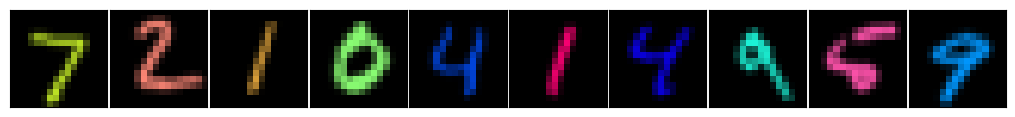

In [8]:
REFERENCE_IMAGES = next(iter(DataLoader(cmnist_test, batch_size=10)))
plot_images(REFERENCE_IMAGES)

In [9]:
class ConvGenerator(nn.Module):

    def __init__(
        self, input_size: int = 128,
        use_batch_norm: bool = True
    ) -> None:
        super().__init__()
        self.n_channels = 64
        self.input_size = input_size
        self.linear_block = nn.Sequential(
            nn.Linear(input_size, 4 * 4 * 4 * self.n_channels),
            nn.ReLU(True),
        )
        self.conv_block = nn.Sequential(
            nn.ConvTranspose2d(4 * self.n_channels, 2 * self.n_channels, 2, stride=2),
            nn.BatchNorm2d(2 * self.n_channels) if use_batch_norm else nn.Identity(),
            nn.ReLU(True),
            nn.ConvTranspose2d(2 * self.n_channels, self.n_channels, 2, stride=2),
            nn.BatchNorm2d(self.n_channels) if use_batch_norm else nn.Identity(),
            nn.ReLU(True),
            nn.Conv2d(self.n_channels, 3, 3, padding=1)
        )
        self.noise = torch.distributions.Normal(torch.tensor(0.0), torch.tensor(1.0))

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        assert input.size(1) == self.input_size
        output = self.linear_block(input)
        output = output.view(-1, 4 * self.n_channels, 4, 4)
        output = self.conv_block(output)
        output = torch.tanh(output)
        return output.view(-1, 3, 16, 16)

    def sample(self, n_samples: int) -> torch.Tensor:
        z = self.noise.sample([n_samples, self.input_size]).to(next(iter(self.parameters())))
        return self.forward(z)

class ConvDiscriminator(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        self.n_channels = 64

        self.net = nn.Sequential(
            nn.Conv2d(3, self.n_channels, 3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(self.n_channels, 2 * self.n_channels, 3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(2 * self.n_channels, 4 * self.n_channels, 3, stride=2, padding=1),
            nn.LeakyReLU(),
        )
        self.linear = nn.Linear(4 * 2 * 2 * self.n_channels, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output = self.net(x)
        output = output.view(-1, 4 * 2 * 2 * self.n_channels)
        output = self.linear(output)
        return output

CG = ConvGenerator()
CD = ConvDiscriminator()

In [17]:
# summary(CG, (128,))

In [18]:
# summary(CD, (3,16,16))

In [ ]:
BATCH_SIZE = 256
CRITIC_STEPS = 2
LR = 2e-3 # < 1e-2
N_EPOCHS = 10 # change it if you want
GP_LAMBDA = 10

train_mnist_loader = DataLoader(cmnist_train, batch_size=BATCH_SIZE, shuffle=True)
G = ConvGenerator(use_batch_norm=False).to(DEVICE)
D = ConvDiscriminator().to(DEVICE)
G_optim = torch.optim.RMSprop(G.parameters(), lr=LR)
D_optim = torch.optim.RMSprop(D.parameters(), lr=LR)
diagnostic = GANDiagnosticCompanionImages(G, D, REFERENCE_IMAGES.numpy())

train_losses = train_wgp(
    train_mnist_loader,
    G,
    D,
    G_optim,
    D_optim,
    critic_steps=CRITIC_STEPS,
    n_epochs=N_EPOCHS,
    diagnostic=diagnostic,
    gp_lambda=torch.tensor(GP_LAMBDA).to(DEVICE),
    visualize_steps=1
)

In [19]:
# diagnostic.visualize()

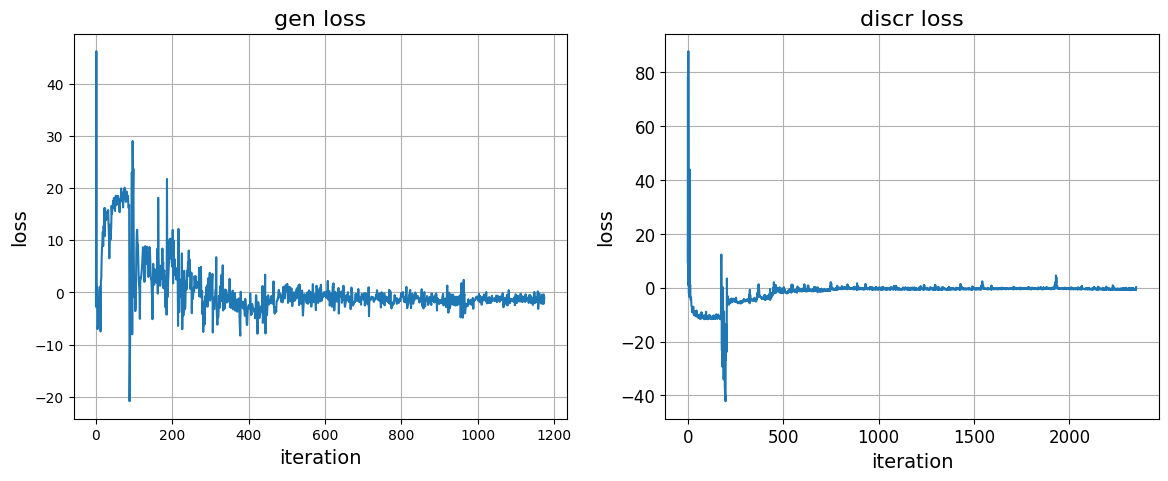

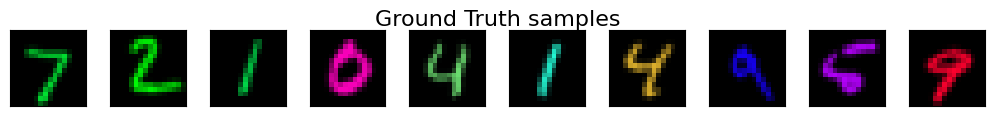

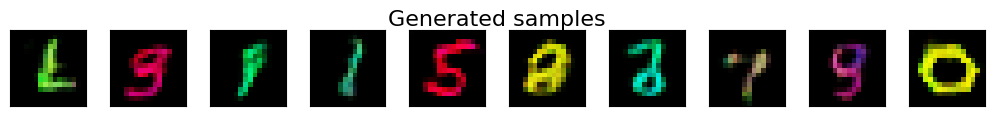

In [ ]:
diagnostic.visualize()